# Layer-wise Relevance Propagation using Abstract Semiring elements for the MNIST Dataset

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import ProvLRP
import ProvLRP_config
from importlib import reload
reload(ProvLRP)

import copy
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## 0. Load dataset

In [3]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 1. Train simple model

In [5]:
# Select the best device to use

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [7]:
def train_model(model, optimizer, loss_fn):
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [8]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

og_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=og_model.parameters(), lr=0.1)

In [9]:
train_model(og_model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35233 | Test loss: 0.15302, Test acc: 95.47%


## 2. Network pruning

### 2.1 LRP

In [10]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in og_model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

X = train.data.reshape((60000, 784)).detach().numpy()
T = train.targets.detach().numpy()

# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

nb_digits = len(train.classes)

In [11]:
R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * np.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [12]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [13]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0.-1
hb = A[0]*0.+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

In [14]:
mean = np.mean(np.abs(R[0]), axis=0).reshape(28,28)

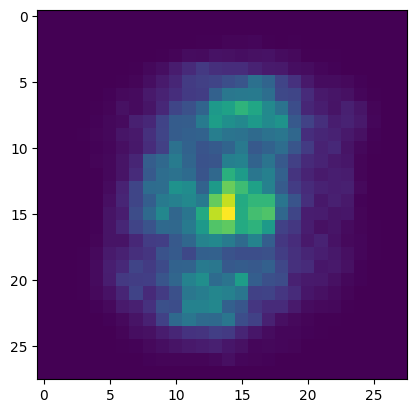

In [15]:
plt.imshow(mean)

In [16]:
class LRPPruningMethod(prune.BasePruningMethod):
    PRUNING_TYPE = 'structured'

    def __init__(self, amount, dim=-1, relevance=None):
        # Check range of validity of amount
        prune._validate_pruning_amount_init(amount)
        self.amount = amount
        self.dim = dim
        self.relevance = relevance

    def compute_mask(self, t, default_mask):
        prune._validate_structured_pruning(t)
        prune._validate_pruning_dim(t, self.dim)

        tensor_size = t.shape[self.dim]
        nparams_toprune = prune._compute_nparams_toprune(self.amount, tensor_size)
        nparams_tokeep = tensor_size - nparams_toprune
        prune._validate_pruning_amount(nparams_toprune, tensor_size)

        # lrp = np.abs(self.relevance)
        # lrp = torch.tensor(np.mean(self.relevance, axis=self.dim))
        lrp = torch.tensor(self.relevance)
        # lrp = torch.abs(lrp)
        topk = torch.topk(lrp, k=nparams_tokeep, largest=True)

        # mask = torch.ones_like(t)
        # slc = [slice(None)] * len(t.shape)
        # slc[self.dim] = topk.indices
        # mask[slc] = 0
        # print(len(topk.indices), len(lrp), tensor_size)
        # for i in range(len(lrp)):
        #     if i not in topk.indices:
        #         lrp[i] = float("inf")

        # _, axs = plt.subplots()
        # axs.imshow(lrp.reshape(28, 28))
        # axs.set_title(f"Pruning of {self.amount} node(s)")
        # plt.show()

        mask = torch.zeros_like(t)
        slc = [slice(None)] * len(t.shape)
        slc[self.dim] = topk.indices
        mask[slc] = 1
        mask *= default_mask.to(dtype=mask.dtype)

        return mask

def lrp_structured(module, name, amount, dim, relevance=None):
    LRPPruningMethod.apply(
        module, name, amount, dim, relevance=relevance,
    )
    return module

#### Counting LRP

In [17]:
SUBSET = 500

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

In [18]:
def rho(w, l):  return w

In [19]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.CountingSemiring

ProvLRP_config.counting_relevance_threshold = 0.5
ProvLRP_config.counting_activation_threshold = 0.1
ProvLRP_config.counting_weight_threshold = 0

# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

nb_digits = len(train.classes)

R_count = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_count[l+1]
    c = s.dot(w.T)
    R_count[l] = semiring.from_activation(A[l]) * c

In [20]:
R_count = [semiring.semiring_to_float(x) for x in R_count]

#### Boolean LRP

In [21]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5
ProvLRP_config.boolean_activation_threshold = 0.1
ProvLRP_config.boolean_weight_threshold = 0

# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

nb_digits = len(train.classes)

R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_bool[l+1]
    c = s.dot(w.T)
    R_bool[l] = semiring.from_activation(A[l]) * c

In [22]:
R_bool = [semiring.semiring_to_float(x) for x in R_bool]

#### Viterbi LRP

In [23]:
R_vit = [None] * L + [A[L] * (T[:,None]==np.arange(nb_digits))]

# All layers even the pixels one
for l in range(0, L)[::-1]:
    R_vit[l] = np.zeros((SUBSET,A[l].shape[1]))
    Z = np.zeros((R_vit[l].shape[1], R_vit[l+1].shape[1], SUBSET))

    for j in range(R_vit[l].shape[1]):
        for k in range(R_vit[l+1].shape[1]):
            Z[j][k] = (A[l][:,j] * W[l][j,k] + B[l][k]) * W[l][j,k]

    sums = np.sum(Z, axis=0)

    for j in range(R_vit[l].shape[1]):
        s = []
        for k in range(R_vit[l+1].shape[1]):
            s.append(Z[j][k]/sums[k] * R_vit[l+1][:,k])
        R_vit[l][:,j] = np.max(s, axis=0)

### 2.3 Pruning

In [24]:
def eval_model(m, print=False):
    test_loss, test_acc = 0, 0
    m.eval()
    with torch.inference_mode():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            test_pred = m(x)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    if print:
        print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.2f}%")
    return test_loss, test_acc

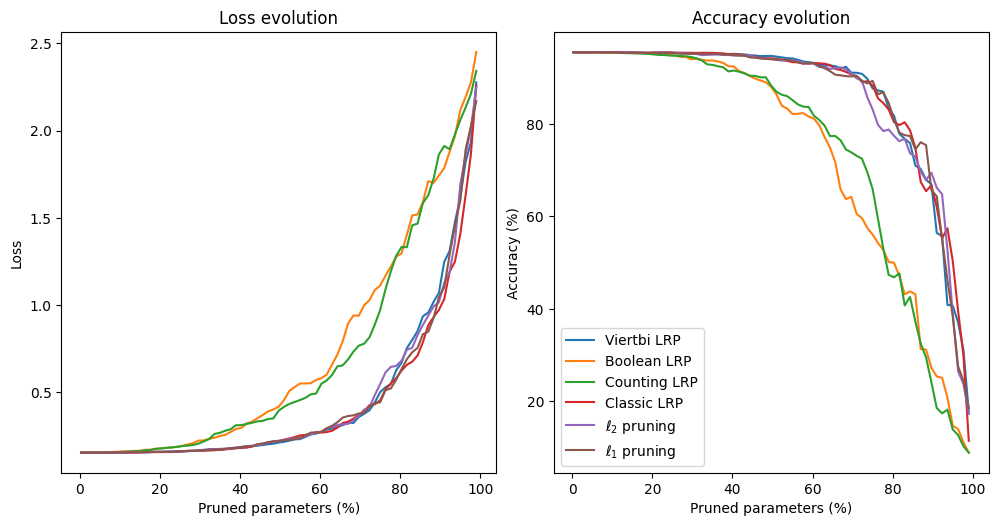

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout()

STEP = 4
DIM = 0
x = np.array(list(range(1, 300, STEP)))

LRPs = [(R_vit, "Viertbi"), (R_bool, "Boolean"), (R_count, "Counting"), (R, "Classic")]


### -- LRP-based pruning --
for (relevance, label_name) in LRPs:
   model = copy.deepcopy(og_model)
   linear1 = list(model.modules())[2]
   linear2 = list(model.modules())[4]

   s = 0
   # losses, accuracies = eval_model(model)
   losses, accuracies = [], []
   for i in x:
      lrp_structured(linear1, name="weight", amount=i, relevance=np.mean(np.abs(relevance[1-DIM]), axis=0), dim=DIM)
      #lrp_structured(linear2, name="weight", amount=i, relevance=R[1], dim=DIM)
      
      prune.remove(linear1, name="weight")
      #prune.remove(linear2, name="weight")
      test_loss, test_acc = eval_model(model)
      losses.append(test_loss)
      accuracies.append(test_acc)

   losses = [l.cpu() for l in losses]
   accuracies = [a for a in accuracies]

   axs[0].plot(x/linear1.weight.shape[DIM]*100, losses, label=label_name+" LRP")
   axs[1].plot(x/linear1.weight.shape[DIM]*100, accuracies, label=label_name+" LRP")

# ### -- Boolean LRP pruning --
# model = copy.deepcopy(og_model)
# linear1 = list(model.modules())[2]
# linear2 = list(model.modules())[4]

# s = 0
# # losses, accuracies = eval_model(model)
# losses, accuracies = [], []
# for i in x:
#    lrp_structured(linear1, name="weight", amount=i, relevance=np.mean(np.abs(R_bool[1-DIM]), axis=0), dim=DIM)
#    #lrp_structured(linear2, name="weight", amount=i, relevance=R[1], dim=DIM)
   
# #    mask = list(linear1.named_buffers())[0][1]
# #    plt.imshow(mask.cpu(), cmap="gray")
# #    plt.show()
   
#    prune.remove(linear1, name="weight")
#    #prune.remove(linear2, name="weight")
#    test_loss, test_acc = eval_model(model)
#    losses.append(test_loss)
#    accuracies.append(test_acc)

# losses = [l.cpu() for l in losses]
# accuracies = [a for a in accuracies]

# axs[0].plot(x/linear1.weight.shape[DIM]*100, losses, label="Boolean LRP")
# axs[1].plot(x/linear1.weight.shape[DIM]*100, accuracies, label="Boolean LRP")


# ### -- Counting LRP pruning --
# model = copy.deepcopy(og_model)
# linear1 = list(model.modules())[2]
# linear2 = list(model.modules())[4]

# s = 0
# # losses, accuracies = eval_model(model)
# losses, accuracies = [], []
# for i in x:
#    lrp_structured(linear1, name="weight", amount=i, relevance=np.mean(np.abs(R_count[1-DIM]), axis=0), dim=DIM)
#    #lrp_structured(linear2, name="weight", amount=i, relevance=R[1], dim=DIM)
   
#    prune.remove(linear1, name="weight")
#    #prune.remove(linear2, name="weight")
#    test_loss, test_acc = eval_model(model)
#    losses.append(test_loss)
#    accuracies.append(test_acc)

# losses = [l.cpu() for l in losses]
# accuracies = [a for a in accuracies]

# axs[0].plot(x/linear1.weight.shape[DIM]*100, losses, label="Counting LRP")
# axs[1].plot(x/linear1.weight.shape[DIM]*100, accuracies, label="Counting LRP")

# ### -- LRP pruning --
# model = copy.deepcopy(og_model)
# linear1 = list(model.modules())[2]
# linear2 = list(model.modules())[4]

# s = 0
# # losses, accuracies = eval_model(model)
# losses, accuracies = [], []
# for i in x:
#    lrp_structured(linear1, name="weight", amount=i, relevance=np.mean(np.abs(R[1-DIM]), axis=0), dim=DIM)
#    #lrp_structured(linear2, name="weight", amount=i, relevance=R[1], dim=DIM)
   
#    prune.remove(linear1, name="weight")
#    #prune.remove(linear2, name="weight")
#    test_loss, test_acc = eval_model(model)
#    losses.append(test_loss)
#    accuracies.append(test_acc)

# losses = [l.cpu() for l in losses]
# accuracies = [a for a in accuracies]

# axs[0].plot(x/linear1.weight.shape[DIM]*100, losses, label="Classic LRP")
# axs[1].plot(x/linear1.weight.shape[DIM]*100, accuracies, label="Classic LRP")



## -- L2 PRUNING --
model = copy.deepcopy(og_model)

linear1 = list(model.modules())[2]
linear2 = list(model.modules())[4]

s = 0
# losses, accuracies = eval_model(model)
losses, accuracies = [], []
for i in x:
    prune.ln_structured(linear1, name="weight", amount=i, n=2, dim=DIM)
    #prune.ln_structured(linear2, name="weight", amount=i, n=2, dim=DIM)

    prune.remove(linear1, name="weight")
    #prune.remove(linear2, name="weight")
    test_loss, test_acc = eval_model(model)
    losses.append(test_loss)
    accuracies.append(test_acc)


losses = [l.cpu() for l in losses]
accuracies = [a for a in accuracies]

axs[0].plot(x/linear1.weight.shape[DIM]*100, losses, label="$\ell_2$ pruning")
axs[1].plot(x/linear1.weight.shape[DIM]*100, accuracies, label="$\ell_2$ pruning")

## -- L1 pruning --
model = copy.deepcopy(og_model)
linear1 = list(model.modules())[2]
linear2 = list(model.modules())[4]

s = 0
# losses, accuracies = eval_model(model)
losses, accuracies = [], []
for i in x:
    prune.ln_structured(linear1, name="weight", amount=i, n=1, dim=DIM)
    #prune.ln_structured(linear2, name="weight", amount=i, n=1, dim=0)
    prune.remove(linear1, name="weight")
    #prune.remove(linear2, name="weight")
    test_loss, test_acc = eval_model(model)
    losses.append(test_loss)
    accuracies.append(test_acc)


losses = [l.cpu() for l in losses]
accuracies = [a for a in accuracies]

axs[0].plot(x/linear1.weight.shape[DIM]*100, losses, label="$\ell_1$ pruning")
axs[1].plot(x/linear1.weight.shape[DIM]*100, accuracies, label="$\ell_1$ pruning")

# ### -- Random pruning --
# model = copy.deepcopy(og_model)
# linear1 = list(model.modules())[2]
# linear2 = list(model.modules())[4]

# s = 0
# # losses, accuracies = eval_model(model)
# losses, accuracies = [], []
# for i in x:
#     prune.random_structured(linear1, name="weight", amount=STEP, dim=DIM)
#     prune.random_structured(linear2, name="weight", amount=STEP, dim=0)
#     test_loss, test_acc = eval_model(model)
#     losses.append(test_loss)
#     accuracies.append(test_acc)

# losses = [l.cpu() for l in losses]
# accuracies = [a for a in accuracies]

# axs[0].plot(x, losses, label="Random pruning")
# axs[1].plot(x, accuracies, label="Random pruning")

# -- PLOTS --
axs[0].set_xlabel("Pruned parameters (%)")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss evolution")

axs[1].set_xlabel("Pruned parameters (%)")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Accuracy evolution")

plt.legend()
plt.show()